# 4.3 Router
#### Using built in helpers like `ToolNode` to execute tool, and `tools_condition` to decide if tool should be executed

Derived from [![LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/)

## Setup

### Install dependencies

In [12]:
%%capture --no-stderr
%pip install python-dotenv~=1.0 --upgrade --quiet
%pip install langchain_core~=0.3.17 langchain_openai~=0.2.6 langchain_community~=0.3.5 --upgrade --quiet
%pip install langgraph~=0.2.46 --upgrade --quiet

# If running locally, you can do this instead:
#%pip install -r ../requirements.txt

### Load environment variables

In [13]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

# If running in Google Colab, you can use this code instead:
# from google.colab import userdata
# os.environ["AZURE_OPENAI_API_KEY"] = userdata.get("AZURE_OPENAI_API_KEY")
# os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get("AZURE_OPENAI_ENDPOINT")

### Setup models

In [14]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
api_version = "2024-10-01-preview"
llm = AzureChatOpenAI(deployment_name="gpt-4o", temperature=0.0, openai_api_version=api_version)

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.  

In [15]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

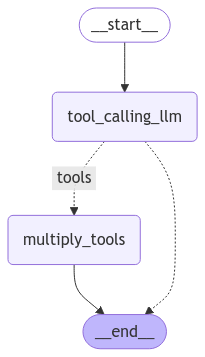

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("multiply_tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "multiply_tools", END: END},
)
builder.add_edge("multiply_tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Multiply 3 and 4.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gbPseerdwGEYrsA4n760FAcB)
 Call ID: call_gbPseerdwGEYrsA4n760FAcB
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

In [29]:
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


For a query unrelated to the tool however, we get a standard `AIMessage`.